# Regresión Logística: Predicción de Enfermedad Coronaria

A continuación se observa un problema de clasificación binaria y se desea analizar una posible solución a partir de un modelo de regresión logística. Se busca implementar el algoritmo mencionado, inicialmente empleando la librería SciKit-Learn para luego desarrollar el mismo proceso de entrenamiento manualmente (Descenso de Gradiente Estocástico).

También se introducirán algunos conceptos para lidiar con datos desbalanceados como: matriz de confusión, curva ROC, y algunas otras métricas importantes.

Debe completar las celdas vacías y seguir las instrucciones anotadas en el cuaderno.

La fecha límite de entrega es el día **20 de septiembre** y se realizará a través de Bloque Neón.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sn
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, RobustScaler
import matplotlib.mlab as mlab
from sklearn.metrics import accuracy_score
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
heart_df=pd.read_csv("/heartDesease/framingham.csv")
heart_df.dropna(axis=0,inplace=True)
heart_df.head()

,male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [ ]:
print(f'Se tienen {len(heart_df)} datos.')

Se tienen 3749 datos.


### Análisis de Distribución de Clases

En el diagrama a continuación puede observar un claro desbalanceo de los datos, en pasos posteriores hablaremos al respecto.

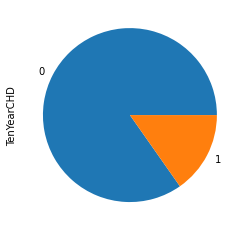

In [ ]:
heart_df['TenYearCHD'].value_counts().plot(kind='pie')

## Descripción de Variables

Cada atributo es un factor potencial de riesgo. Existen factores demográficos, conductuales y médicos.

- Demográfico:

    - male: masculino (1) o femenino (0); (Nominal)

    - age: edad del paciente; (Continuo: aunque las edades registradas se han truncado a números enteros, el concepto de edad es continuo)

- Comportacional:

    - currentSmoker: si el paciente es o no fumador actual (nominal)

    - cigsPerDay: la cantidad de cigarrillos que la persona fumó en promedio en un día (se puede considerar continuo ya que uno puede tener cualquier cantidad de cigarrillos, incluso medio cigarrillo).

- Historia médica:

    - BPMeds: si el paciente estaba o no tomando medicación para la presión arterial (nominal)

    - prevalentStroke: si el paciente había tenido previamente un accidente cerebrovascular o no (nominal)

    - prevalentHyp: si el paciente era hipertenso (nominal)

    - diabetes: si el paciente tenía diabetes o no (nominal)

- Estado Médico actual:

    - totChol: nivel de colesterol total (continuo)

    - sysBP: presión arterial sistólica (continua)

    - diaBP: presión arterial diastólica (continua)

    - IMC: índice de masa corporal (continuo)

    - heartRate: frecuencia cardíaca (continua: en la investigación médica, variables como la frecuencia cardíaca, aunque de hecho son discretas, se consideran continuas debido a la gran cantidad de valores posibles).

    - glucose: nivel de glucosa (continuo)

- **Variable a Predecir**

    - TenYearCHD: Riesgo de padecer enfermedad coronaria 10 años en el futuro (binario: "1", significa "Sí", "0" significa "No")

In [ ]:
x = heart_df.values
scaler = MinMaxScaler() # Utilice un MinMaxScaler en esta ocasión #
x_scaled = scaler.fit_transform(x) # Aplique el escalamiento #
heart_df_scaled = pd.DataFrame(x_scaled, columns=heart_df.columns) # Conversión a un DataFrame #

In [ ]:
x = heart_df_scaled.iloc[:,:-1]
y = heart_df_scaled.iloc[:,-1]

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=20)

## Parte 1

A continuación, debe utilizar la función `LogisticRegression` de SciKit-Learn para obtener un primer modelo de regresión logística y calcular su precisión a partir de la función `accuracy_score`.

Obtenga resultados sobre los datos de entrenamiento y los datos de prueba. Concluya al respecto.

In [ ]:
logreg = LogisticRegression() # Modelo de Regresión Logística #
logreg.fit(x_train, y_train) # Entrenamiento sobre los Datos #
y_pred = logreg.predict(x_test) # Predicción de Etiquetas #
score = accuracy_score(y_test, y_pred)
print(f'Precisión inicial: {score}')

Precisión inicial: 0.8453333333333334


Al parecer el modelo usado funciona bien para determinar si las personas van a sufrir o no de enfermedad coronaria en los próximos 10 años. Sin embargo, no se ha tenido en cuenta que los datos se encuentran desbalanceados puesto a que una pequeña fracción de la población sufre de esta enfermedad. Por lo tanto, se podría decir que el modelo será exitoso entre una mayor cantidad de verdaderos positivos sean clasificados como positivos, sin perder a la vez la efectividad de identificar verdaderos negativos.

### Matriz de Confusión

Como recordará, la información en este dataset no posee una distribución de clases balanceada. La matriz de confusión es una herramienta que permite analizar el comportamiento del modelo para estos datos.

Puede encontrar más información en este artículo: [Understanding Confusion Matrix](https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62)

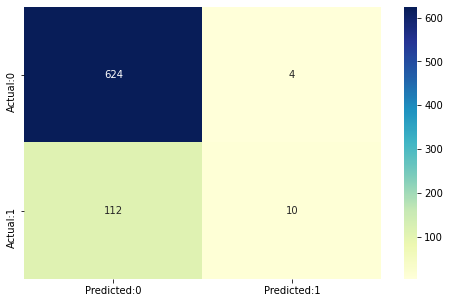

In [ ]:
cm = confusion_matrix(y_test,y_pred)
conf_matrix = pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sn.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

Aquí se logra evidenciar lo que se mencionó anteriormente, de 112 positivos únicamente se pudo indentificar a 10. Entonces, como los datos están desbalanceados, el resultado de nuestro modelo también lo está. Se tienen muchos más negativos que positivos, incluso cuando estos en realidad son positivos. Más adelante, se evidencian métricas que serán de gran utilidad para seleccionar el mejor modelo para este problema.

### Tratamiento de Datos Desbalanceados

En casos de estudio como identificación de tendencias patológicas, es común tener datos desbalanceados, o en los cuales la gravedad de cometer [errores tipo I o tipo II](https://www.simplypsychology.org/type_I_and_type_II_errors.html) son bastante diferentes. En muchos casos, se puede preferir cometer cierto tipo de error sobre el otro. Para trabajar con estos problemas, se suele preferir sacrificar algo de [precisión](https://developers.google.com/machine-learning/crash-course/classification/accuracy) del modelo, a cambio de una mejora en términos prácticos.

Este proceso se realiza a partir de la modificación del umbral a partir del cual se decide si un dato pertenece a una clase u otra. Utilice la función `binarize` para obtener valores de `0` ó `1` según las probabilidades de las predicciones realizadas utilizando la función `model.predict_proba`.

Algunas métricas utilizadas para interpretar el rendimiento del modelo son las siguientes:

- F1Score
- TP Rate / Recall / Sensitividad
- TN Rate / Especificidad

Puede encontrar más información sobre estas métricas en los artículos:
- [Accuracy, Precision, Recall or F1?](https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9)
- [Sensitivity Vs Specificity In Data Science](https://medium.com/fintechexplained/sensitivity-vs-specificity-in-data-science-2f673039dbd1)

In [ ]:
from sklearn.preprocessing import binarize

umbrales = np.arange(0,.4,0.005)# Vector que Contiene los Umbrales a Analizar #
for umbral in umbrales:
    cm2 = 0
    y_pred_prob_yes = logreg.predict_proba(x_test) # Utilice la función predict_proba para calcular las probabilidades de pertenecer a la clase 1 #
    y_pred2 = binarize(y_pred_prob_yes, threshold = umbral)# Utilice la función binarize para convertir las probabilidades a clases 0 y 1 #
    cm2 = confusion_matrix(y_test,y_pred2[:,1])
    print(f'''->Para un umbral de {round(umbral,4)} tenemos esta matriz de confusión:
{cm2}
Con {cm2[0,0]+cm2[1,1]} predicciones correctas y {cm2[1,0]} falsos negativos.
Sensitividad: {round(cm2[1,1]/(float(cm2[1,1]+cm2[1,0])), 4)} Especificidad: {round(cm2[0,0]/(float(cm2[0,0]+cm2[0,1])), 4)}\n''')


->Para un umbral de 0.0 tenemos esta matriz de confusión:
[[  0 628]
 [  0 122]]
Con 122 predicciones correctas y 0 falsos negativos.
Sensitividad: 1.0 Especificidad: 0.0

->Para un umbral de 0.005 tenemos esta matriz de confusión:
[[  0 628]
 [  0 122]]
Con 122 predicciones correctas y 0 falsos negativos.
Sensitividad: 1.0 Especificidad: 0.0

->Para un umbral de 0.01 tenemos esta matriz de confusión:
[[  0 628]
 [  0 122]]
Con 122 predicciones correctas y 0 falsos negativos.
Sensitividad: 1.0 Especificidad: 0.0

->Para un umbral de 0.015 tenemos esta matriz de confusión:
[[  0 628]
 [  0 122]]
Con 122 predicciones correctas y 0 falsos negativos.
Sensitividad: 1.0 Especificidad: 0.0

->Para un umbral de 0.02 tenemos esta matriz de confusión:
[[  0 628]
 [  0 122]]
Con 122 predicciones correctas y 0 falsos negativos.
Sensitividad: 1.0 Especificidad: 0.0

->Para un umbral de 0.025 tenemos esta matriz de confusión:
[[  6 622]
 [  0 122]]
Con 128 predicciones correctas y 0 falsos negativos

Por otra parte, un criterio que facilita el visualizar este trade-off se conoce como la Curva ROC, en donde se ubican múltiples puntos para distintos valores del umbral de clasificación. Puede leer el artículo a continuación para una explicación más detallada:
- Curva ROC: [Understanding AUC - ROC Curve](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5)

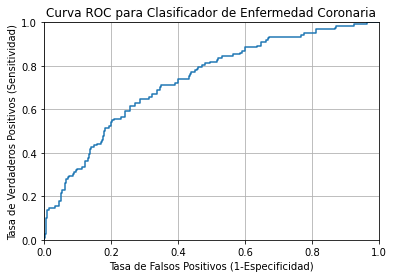

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_yes[:,1])
plt.plot(fpr,tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('Curva ROC para Clasificador de Enfermedad Coronaria')
plt.xlabel('Tasa de Falsos Positivos (1-Especificidad)')
plt.ylabel('Tasa de Verdaderos Positivos (Sensitividad)')
plt.grid(True)

Observe la gráfica, y teniendo en cuenta los resultados concluya sobre la proporción que se puede considerar más adecuada en este contexto.

Anteriormente, se mencionó que nuestro modelo iba a resultar exitoso si podía identificar con mayor eficacia los casos verdaderamente positivos por encima de aquellos que eran negativos puesto a que los datos en un inicio se encontraban desbalanceados. Es decir, para este caso en específico yo voy a dar un mayor valor a la sensitividad que a la especifidad del modelo; a su vez, como también mencione anteriormente tampoco me parece bien sacrificar toda la especifidad. Por lo tanto, considero que un buen rango en el umbral es de [0.115, 0.145], de tal forma que si la probabilidad de los datos se encuentra por encima de estos umbrales (para la clase 1) estos se consideran como un 1.

## Parte 2

Ahora usted debe desarrollar su propia implementación del método Descenso de Gradiente estocástico para un modelo de regresión logística. Realice el entrenamiento a partir del 80% de los datos. Al final del entrenamiento, en la lista errores se deben tener los valores de la función de error para cada iteración y así poder observar el progreso gráficamente.

In [ ]:
import time
X_train_array = np.c_[np.ones(x_train.values.shape[0]), x_train.values]
y_train_array = y_train.values

w0 = np.random.rand(X_train_array.shape[1]) # Inicialización de w #

w = w0.copy()
# Inicialización de criterio de parada (al disminuir el valor de eps, se aumenta la precisión y el tiempo de procesamiento)
eps = 1e-3
error = 100
dif = 100
errores = [] 

def sigma(w,x):
    res_sigmoid = 1/(1+np.exp(-np.dot(w.T,x))) # Salida de la función sigmoide #
    return res_sigmoid

tasas = np.arange(0.001,0.01,0.001)# Defina un vector que contenga las tasas que desea probar #
m = 1000  #Numero de indices para observar en los mini batches

for tasa in tasas:
  t0 = time.time()
  while error>eps:         # Criterio de parada 1 #
    X = X_train_array
    Y = y_train_array
    e = 0
    grad = 0
    lista_mini_batch = np.random.randint(0,len(X_train_array), m)   # Para no recorrer los mismos 1000 puntos hice uso de esta lista
    for j in lista_mini_batch:  # Se recorren m elementos de la lista mini batch sobre los datos de entrenamiento
      g = sigma(w,X[j])
      e += Y[j]-g   #Variable que guarda los errores 
      grad += tasa*e*X[j]   # Variable que guarda el valor del gradiente
    wn = w + grad/m   #Se toma el promedio del gradiente para aumentar al vector 2
    error = np.linalg.norm(wn-w)
    errores.append(error)
    w = wn
    X_test_array = np.c_[np.ones(x_test.values.shape[0]), x_test.values]
    y_test_array = y_test.values

    y_pred = np.zeros(len(x_test))
  t1 = time.time()
  for i in range(0,len(x_test)):
    prob = sigma(w,X_test_array[i])
    if prob>0.5:
      y_pred[i] = 1
    else:
      y_pred[i] = 0
  cm = confusion_matrix(y_test,y_pred)

  print(f'''Precisión modelo actual: {sklearn.metrics.accuracy_score(y_test,y_pred)} Tasa: {tasa}
        Tiempo en cumplir la condicion eps: {t1-t0}\n''')

Precisión modelo actual: 0.8373333333333334 Tasa: 0.001
        Tiempo en cumplir la condicion eps: 0.24072718620300293

Precisión modelo actual: 0.8373333333333334 Tasa: 0.002
        Tiempo en cumplir la condicion eps: 1.9073486328125e-06

Precisión modelo actual: 0.8373333333333334 Tasa: 0.003
        Tiempo en cumplir la condicion eps: 1.430511474609375e-06

Precisión modelo actual: 0.8373333333333334 Tasa: 0.004
        Tiempo en cumplir la condicion eps: 1.6689300537109375e-06

Precisión modelo actual: 0.8373333333333334 Tasa: 0.005
        Tiempo en cumplir la condicion eps: 1.430511474609375e-06

Precisión modelo actual: 0.8373333333333334 Tasa: 0.006
        Tiempo en cumplir la condicion eps: 1.430511474609375e-06

Precisión modelo actual: 0.8373333333333334 Tasa: 0.007
        Tiempo en cumplir la condicion eps: 1.6689300537109375e-06

Precisión modelo actual: 0.8373333333333334 Tasa: 0.008
        Tiempo en cumplir la condicion eps: 1.430511474609375e-06

Precisión modelo a

## Matriz de Confusión

Observe y analice la matriz de confusión para su mejor modelo. Escriba claramente sus conclusiones.

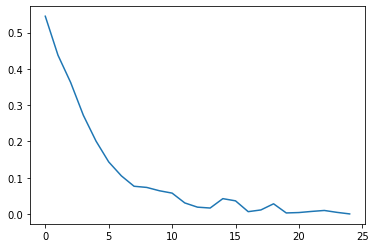

In [ ]:
plt.plot(errores)

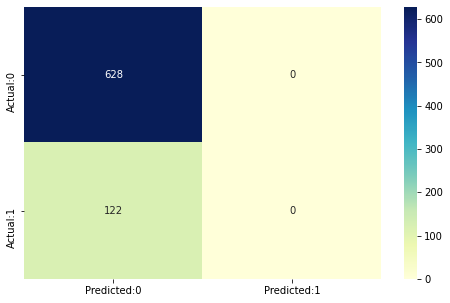

In [ ]:
cm = confusion_matrix(y_test,y_pred)
conf_matrix = pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])

plt.figure(figsize = (8,5))
sn.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

Se ejecutó el modelo con distintas tasas de cambio; sin embargo, las que se mostraron corresponden a aquellas en dónde se observa la mejor gráfica del error y en donde se empieza a evidenciar los problemas de coger tasas muy altas. Aunque la gráfica para el error desciende de manera satisfactoria, hay una especie de ascensos que resultan como consecuencia de tener unas tasas de aprendizaje más altas, tanto así que para tasas de aprendizaje mayores a 0.1 los tiempos de convergencia aumentaron de manera considerable puesto a que los pasos dados eran muy grandes para las características del set de datos. Dado a que no se hicieron cambios en la discriminación entre clases también se observa el desbalanceo que hay sobre los datos; eso sí, se realizaron pruebas cambiando el umbral y se obtienen resultados más satisfactorios. 